## Setup
- ipynb magics
- downloading spacy transformer and models
- imports
- version checking
- downloading model and word map

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2b

In [2]:
# Download spacy transformer models, might take a small while, ~500MB
# These also require nvidia-ml-py3 which is slightly problematic
# !pip install spacy-pytorch-transformers
# !python -m spacy download en_pytt_xlnetbasecased_lg
# After doing this restart kernel

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import scipy
import os
import gdrive_download
import json
from pathlib import Path
from IPython.display import Image, display
import PIL
import random
import caption
from operator import itemgetter

In [43]:
print(f'torch version: \t\t {torch.__version__}')
print(f'torchvision version: \t {torchvision.__version__}')
print(f'scipy version: \t\t {scipy.__version__}')

torch version: 		 1.0.1
torchvision version: 	 0.2.2
scipy version: 		 1.3.0


In [5]:
# Download pretrained model resnet101 (~700MB)
# This model has been pretrained on imagenet, then on mscoco2014
gdrive_download.download('1FYZ446OPEqhe-uLkgyVICjD_3-N3IZn1', 'resnet.pth.tar')

# Download the word map (~100KB)
gdrive_download.download('1bt_TmTC_rUcss2MJsG_C_6DtwEttRVKc', 'word_map.json')

resnet.pth.tar already exists
word_map.json already exists


In [6]:
# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load to cpu if no cuda available, else load to cpu
if device==torch.device('cpu'):
    checkpoint = torch.load('resnet.pth.tar', map_location=lambda storage, loc: storage);
else:
    checkpoint = torch.load('resnet.pth.tar');
print(f'Model loaded to {device}')
    
# Load the word map
with open('word_map.json') as json_file:
    data = json.load(json_file)
    
; # Warnings hidden

C:\Users\charl\Anaconda3\envs\imgsim\lib\site-packages\torch\serialization.py:435: SourceChangeWarning: source code of class 'models.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\charl\Anaconda3\envs\imgsim\lib\site-packages\torch\serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\charl\Anaconda3\envs\imgsim\lib\site-packages\torch\serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the obj

Model loaded to cpu


'# Warnings hidden'

In [7]:
# Load the seperate components of the model
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open('word_map.json', 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

# Load the word map

### Inference example images

In [8]:
def seq_to_sentence(seq, rev_word_map):
    # Sentence from token sequence `seq`, remove <start> & <end> tokens
    sentence_words = [rev_word_map[idx] for idx in seq]
    sentence = ' '.join(sentence_words[1:-1])
    return sentence

def caption_image(im_path):
    seq, _ = caption.caption_image_beam_search(encoder, decoder,
                                               im_path, word_map, 5)
    return seq_to_sentence(seq, rev_word_map)


In [9]:
img_paths = list(Path('example_photos').glob('*.jpg'))

C:\Users\charl\Anaconda3\envs\imgsim\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


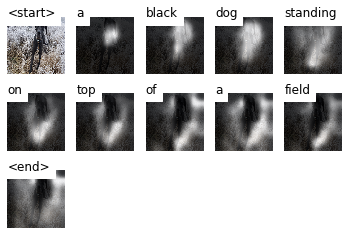

In [10]:
#im_path = random.choice(img_paths)
im_path = img_paths[26] # Luna in a field

# Encode, decode with attention and beam search
seq, alphas = caption.caption_image_beam_search(encoder, decoder, im_path, word_map, 5)
alphas = torch.FloatTensor(alphas)

# Visualize caption and attention of best sequence
caption.visualize_att(im_path, seq, alphas, rev_word_map)

In [11]:
seq_to_sentence(seq, rev_word_map)

'a black dog standing on top of a field'

### So far...
The resnet encoder encodes an image.
A decoder LSTM and attention network create a caption.

Now I need to check the caption to target sentences for their semantic similarity.

### NLP

https://medium.com/better-programming/the-beginners-guide-to-similarity-matching-using-spacy-782fc2922f7c

a body of water with a building in the background


In [13]:
import spacy

In [14]:
# The large language model is needed as it contains pre-trained word vectors. 
#!python -m spacy download en_core_web_lg
# then restart kernel
nlp = spacy.load('en_core_web_lg')

In [49]:
# Get the sentences to compare
im_capt = caption_image(img_paths[32])

sentences = ['a lake in a village', 
           'a dog playing with a boy', 
           'a river flowing near a building',
          '"what the hell?"',
          'To assemble chair, please have patience.']

In [50]:
# Convert the sentences to spacy docs
sentences = [nlp(s.lower()) for s in sentences]
im_capt = nlp(im_capt)

In [51]:
rated_sentences = []
for sentence in sentences:
    score = im_capt.similarity(sentence)
    rated_sentences.append((score, sentence))

rated_sentences = sorted(rated_sentences, key=itemgetter(0),
                         reverse=True)
rated_sentences

[(0.8395940719907433, a river flowing near a building),
 (0.8173804634970113, a lake in a village),
 (0.7860964613882866, a dog playing with a boy),
 (0.6732222628237201, to assemble chair, please have patience.),
 (0.6497713321667429, "what the hell?")]

In [52]:
sentences

[a lake in a village,
 a dog playing with a boy,
 a river flowing near a building,
 "what the hell?",
 to assemble chair, please have patience.]